In [1]:
import os
import torch
import argparse
import sys
sys.path.append("/lid/home/saydalie/multimodal_cot")
sys.path.append("/lid/home/saydalie/multimodal_cot/anole")

from PIL import Image
from anole.chameleon.inference.chameleon import ChameleonInferenceModel, Options
from anole.constants import (
    MODEL_7B_PATH,
    TOKENIZER_TEXT_PATH,
    TOKENIZER_IMAGE_CFG_PATH,
    TOKENIZER_IMAGE_PATH,
)
from typing import List, Tuple

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def split_token_sequence(
    tokens: torch.LongTensor,
    boi: int,
    eoi: int
) -> List[Tuple[str, torch.LongTensor]]:
    """
    Split a sequence of tokens into text and image segments.
    
    Args:
        tokens (torch.LongTensor): The token sequence.
        boi (int): Begin of image token.
        eoi (int): End of image token.
    
    Returns:
        List[Tuple[str, torch.LongTensor]]: List of tuples indicating segment type and tokens.
    """
    batch_size, _ = tokens.shape
    assert batch_size == 1, "Batch size must be 1"
    
    device = tokens.device
    tokens = tokens[0]  # remove batch dimension
    tokens = tokens.to(device)
    segments = []
    current_segment = []
    in_image_seg = False

    for token in tokens:
        if token == boi:
            # if entering an image segment, save the current text segment (if any)
            if current_segment:
                segments.append(("text_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
                current_segment = []
            in_image_seg = True
        elif token == eoi and in_image_seg:
            # if exiting an image segment, save the current image segment
            segments.append(("image_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
            current_segment = []
            in_image_seg = False
        else:
            current_segment.append(token)
    # save any remaining tokens
    if current_segment:
        if in_image_seg:
            segments.append(("image_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
        else:
            segments.append(("text_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
    return segments

In [3]:
# Load Chameleon model
model = ChameleonInferenceModel(
    MODEL_7B_PATH.as_posix(),
    TOKENIZER_TEXT_PATH.as_posix(),
    TOKENIZER_IMAGE_CFG_PATH.as_posix(),
    TOKENIZER_IMAGE_PATH.as_posix(),
)
# Print model configuration
print(f"Model path: {MODEL_7B_PATH}")
print(f"Text tokenizer path: {TOKENIZER_TEXT_PATH}")
print(f"Image tokenizer config path: {TOKENIZER_IMAGE_CFG_PATH}")
print(f"Image tokenizer path: {TOKENIZER_IMAGE_PATH}")

VQModel loaded from /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/tokenizer/vqgan.ckpt
Model path: /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/models/7b
Text tokenizer path: /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/tokenizer/text_tokenizer.json
Image tokenizer config path: /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/tokenizer/vqgan.yaml
Image tokenizer path: /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/tokenizer/vqgan.ckpt


In [4]:
# Generate options
options = Options()
options

Options(max_seq_len=4096, max_gen_len=4096, seed=None, txt=Options.Text(repetition_penalty=1.2, temp=1.0, top_p=0.9, greedy=False), img=Options.Image(cfg=Options.Image.CFG(guidance_scale_text=3.0, guidance_scale_image=1.2), temp=0.7, top_p=0.9, greedy=False), extra_eos_tokens=[])

In [37]:
import PIL
img = PIL.Image.open('/lid/home/saydalie/multimodal_cot/anole/assets/stop_sign.png')
img_tokens = model.token_manager.image_tokenizer.img_tokens_from_pil(img)
img_tokens.shape

torch.Size([1024])

In [56]:
batch_prompt_ui = [
    [
        {"type": "image", "value": "file:/lid/home/saydalie/multimodal_cot/anole/assets/stop_sign.png"},
        {"type": "text", "value": "Modify the given image to remove the stop sign."}
    ],
]
batch_prompt_ui

[[{'type': 'image',
   'value': 'file:/lid/home/saydalie/multimodal_cot/anole/assets/stop_sign.png'},
  {'type': 'text',
   'value': 'Modify the given image to remove the stop sign.'}]]

In [57]:
batch_input_ids = [
    model.token_manager.tokens_from_ui(prompt_ui)
    for prompt_ui in batch_prompt_ui
]

In [58]:
import numpy as np
# 0 -> `bos`
print('`boi` tokens:', np.where(np.array(batch_input_ids[0]) == 8197)[0])
print('`eoi` tokens:', np.where(np.array(batch_input_ids[0]) == 8196)[0])

# each image is of 1024 tokens
# [<img_tokens>, ..., <img_tokens>, <txt_tokens>]

`boi` tokens: [1]
`eoi` tokens: [1026]


In [59]:
# generate
tokens: torch.LongTensor = model.generate(
    batch_prompt_ui=batch_prompt_ui,
    options=options
)

In [60]:
# split
boi, eoi = model.vocab.begin_image, model.vocab.end_image   # 8197(boi), 8196(eoi)
segments = split_token_sequence(tokens, boi, eoi)

for seg_type, seg_tokens in segments:
    print(seg_type, ':', seg_tokens.shape)

text_seg : torch.Size([1, 64])
image_seg : torch.Size([1, 1024])
text_seg : torch.Size([1, 1])


 

Here is an image of a stop sign, a wooden pole, and a tree. The stop sign has red, white, and black colors. The stop sign has vines wrapped around the bottom. The tree is a deciduous tree with green leaves. Here is the image with the stop sign removed:


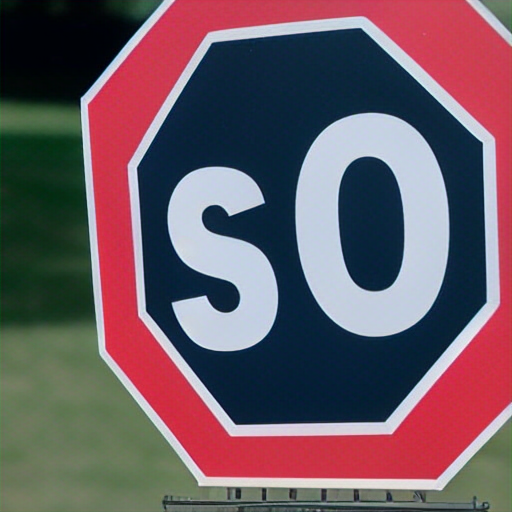

In [61]:
# decode
for seg_id, (seg_type, seg_tokens) in enumerate(segments):
    if seg_type == "image_seg":
        assert seg_tokens.shape[1] == 1024
        img: Image = model.decode_image(seg_tokens)[0]
        img.show()
    else:
        assert seg_type == "text_seg"
        decoded_text = model.decode_text(seg_tokens)[0]
        print(decoded_text)